In [25]:
# Libraries
import os
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import tensorflow as tf
from numpy import argmax
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import IPython.display as Ipd
import random
import warnings
from PIL import Image
import pathlib
import csv
import sklearn
import seaborn

In [26]:
# We define a specific seed so that results are repeatable:
from numpy.random import seed
from tensorflow.random import set_seed
seed(0)
set_seed(0)

## Audio Analysis:

For our basic neural network we will use Librosa to create an input dataset. We begin by calculating numerical values describing different features of the audio files. Then, we collect the means and variances of these values for each audio file into a dataframe. Our model will essentially use these values to compare each sample. We demonstrate how we calculate each feature below using our jazz.00035.wav file as an example.

In [60]:
# Note to reader: Change the path variable to suit the location of the dataset file on your device.
path = 'C:/Users/Joshua/Documents/University/Year-3/Intro-to-AI/Data'

# We use Librosa to calculate the amplitude (y) and frequency (sampling rate (sr)) of the sound waves in our audio file.
y, sr = librosa.load(f'{path}/genres_original/jazz/jazz.00035.wav')

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

# Assert that our data is correct by using it to calculate the length of our audio file and verifying that it is ~30 seconds.
calc_length = np.shape(y)[0]/sr
np.testing.assert_almost_equal(actual = calc_length, desired = 30, decimal = 2, verbose=True)

# Trim y to remove leading and trailing silence if it exists, and define this to be the sample that we will work with.
sample = np.array(librosa.effects.trim(y))[0]

print("Sample (trimmed y):", sample)

y: [-0.03414917 -0.04660034 -0.02764893 ... -0.01467896 -0.02035522
 -0.01965332] 

y shape: (661794,) 

Sample Rate (KHz): 22050 

Sample (trimmed y): [-0.03414917 -0.04660034 -0.02764893 ... -0.01467896 -0.02035522
 -0.01965332]


## Zero Crossing Rate:
- The rate at which a signal changes from positive to negative or negative to positive. Can be interpreted as a measure of noisiness of a signal.



In [63]:
# Using our jazz sample:
y, sr = librosa.load(f'{path}/genres_original/jazz/jazz.00035.wav')
sample = np.array(librosa.effects.trim(y))[0]

zero_crossings = librosa.zero_crossings(sample, pad=False)
print("Zero crossings: ", sum(zero_crossings))

Zero crossings:  25006


## Harmonic and percussive decomposition:
- Decomposing our audio time series into its harmonic and percussive parts.

Text(0, 0.5, 'Amplitude')

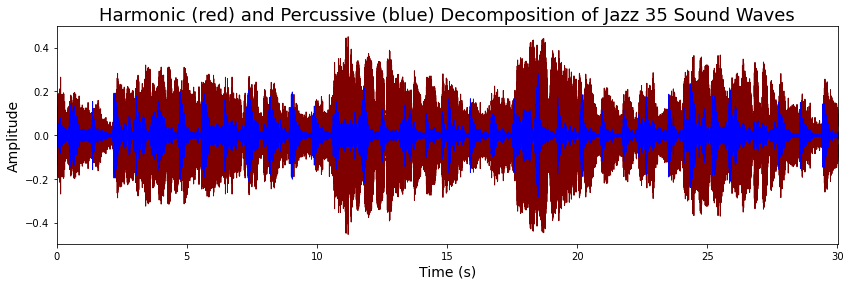

In [94]:
y_harmonic, y_percussive = librosa.effects.hpss(sample)

plt.figure(figsize = (14, 4))
librosa.display.waveplot(y = y_harmonic, sr = sr, color = "maroon");
librosa.display.waveplot(y = y_percussive, sr = sr, color = "blue");
plt.title("Harmonic (red) and Percussive (blue) Decomposition of Jazz 35 Sound Waves", fontsize = 18);
plt.xlabel("Time (s)", fontsize = 14)
plt.ylabel("Amplitude", fontsize = 14)

## Tempo (BPM):
- Pace of the beat

In [30]:
tempo = librosa.beat.beat_track(sample, sr = sr)[0]
print("Tempo: ", tempo)

Tempo:  71.77734375


## Spectral Centroid:
- Identifies where the "centre of mass" of a spectrum is located; more specifically, it is the weighted mean of the frequencies present in the signal.

Text(0, 0.5, 'Amplitude')

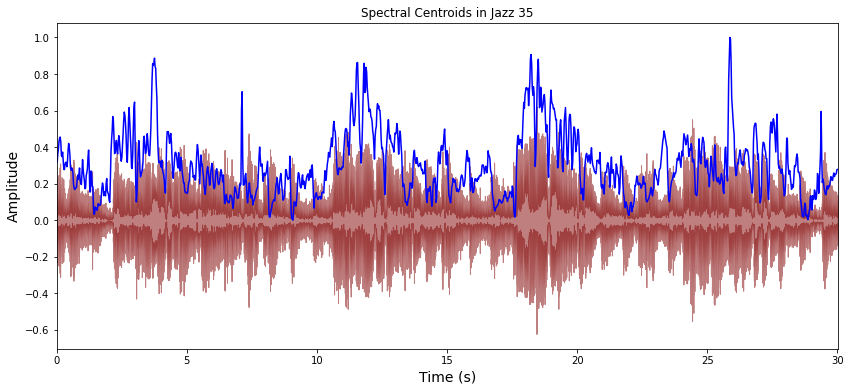

In [93]:
spectral_centroids = librosa.feature.spectral_centroid(sample, sr=sr)[0]

frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

#Plotting the Spectral Centroid along the waveform
plt.figure(figsize = (14, 6))
librosa.display.waveplot(sample, sr=sr, alpha=0.5, color = 'maroon');
plt.plot(t, normalize(spectral_centroids), color='blue');
plt.title('Spectral Centroids in Jazz 35')
plt.xlabel('Time (s)', fontsize = 14)
plt.ylabel('Amplitude', fontsize = 14)

## Spectral Rolloff:
- The frequency below which a specified percentage of the total spectral energy lies.

Text(0, 0.5, 'Amplitude')

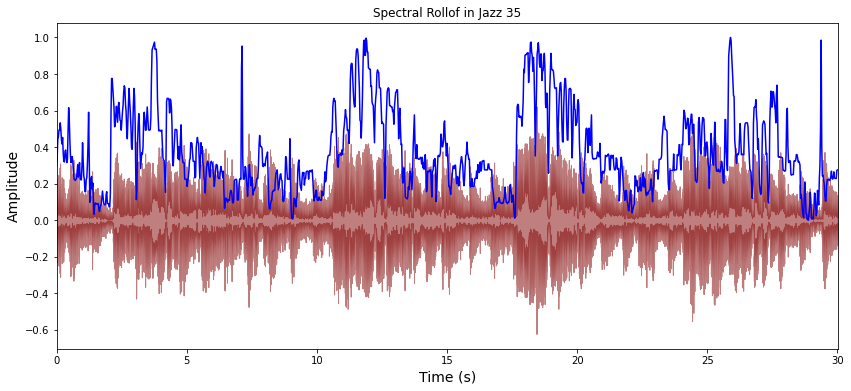

In [92]:
plt.figure(figsize = (14,6))
spectral_rolloff = librosa.feature.spectral_rolloff(sample, sr=sr)[0]
librosa.display.waveplot(sample, sr=sr, alpha=0.5, color = 'maroon')
plt.plot(t, normalize(spectral_rolloff), color='blue')
plt.title('Spectral Rollof in Jazz 35')
plt.xlabel('Time (s)', fontsize = 14)
plt.ylabel('Amplitude', fontsize = 14)

## Mel-Frequency Cepstral Coefficients:

A Mel-frequency cepstrum (MFC) represents the short-term power spectrum of a signal. It is composed of (in our case) 20 Mel-frequency cepstrum coefficiencts (MFCCs).

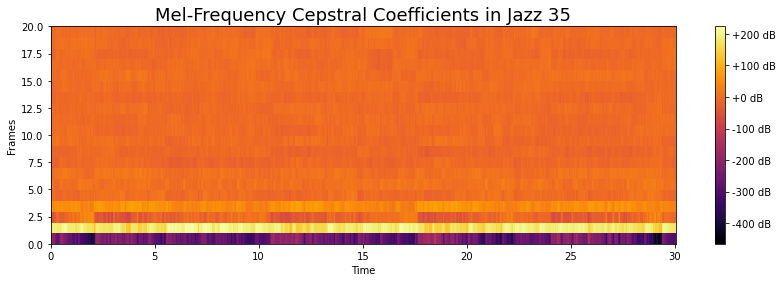

In [91]:
mfccs = librosa.feature.mfcc(sample, sr=sr, n_mfcc=20)
plt.figure(figsize = (14, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', y_axis = 'frames', cmap = 'inferno');
plt.title('Mel-Frequency Cepstral Coefficients in Jazz 35', fontsize = 18);
plt.colorbar(format='%+2.0f dB');

Variance: 1.0


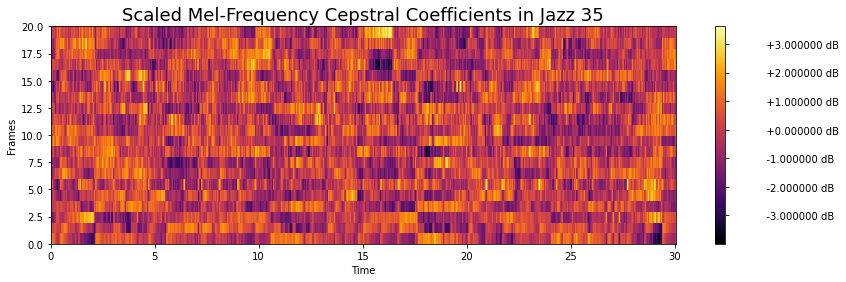

In [90]:
# We normalise the data to have variance of 1.
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print('Variance:', mfccs.var())

plt.figure(figsize = (14, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time',y_axis = 'frames', cmap = 'inferno');
plt.title('Scaled Mel-Frequency Cepstral Coefficients in Jazz 35', fontsize = 18);
plt.colorbar(format='%+20f dB');

## Chroma Features:
Chroma features are a visual representation of audio in which the entire spectrum is projected onto 12 bins, where each bin represets one of the 12 distinct semitones of the musical octave.

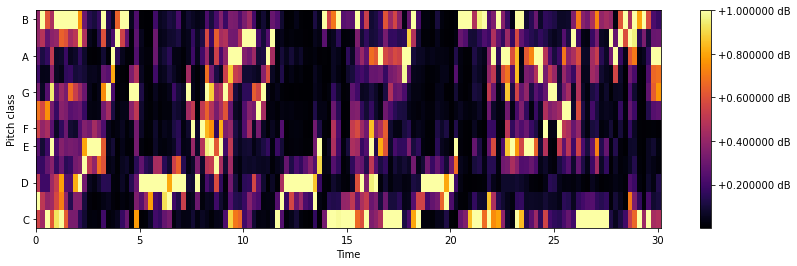

In [35]:
# Define hop length (number of samples between successive frames):
hop_length = 5000

chromagram = librosa.feature.chroma_stft(sample, sr=sr, hop_length=hop_length)
plt.figure(figsize=(14, 4))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='inferno');
plt.colorbar(format='%+0f dB');

## Princpal Component Analysis on genres

In [36]:
from sklearn import preprocessing
# Working with the characteristics dataset for our 30 second audio files:
data = pd.read_csv(f'{path}/features_30_sec.csv')
data = data.iloc[0:, 1:]
x = data.loc[:, data.columns != 'label']
y = data['label']

from sklearn.preprocessing import StandardScaler
# Normalise data
scaler = sklearn.preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
x = pd.DataFrame(x_scaled, columns = x.columns)


# Principal Component Analysis
from sklearn.decomposition import PCA

principal_components = PCA(n_components=2).fit_transform(x)
principal_dataframe = pd.DataFrame(data = principal_components, columns = ['principal component 1', 'principal component 2'])
dataframe = pd.concat([principal_dataframe, y], axis = 1)

Text(0, 0.5, 'Principal Component 2')

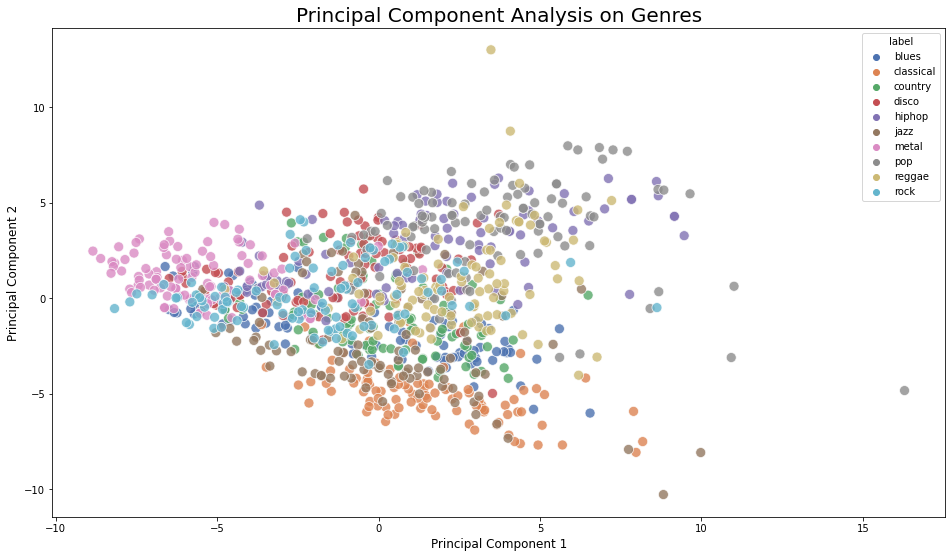

In [37]:
import seaborn as sns

plt.figure(figsize = (16, 9))
sns.set_palette("deep")
sns.scatterplot(x = "principal component 1", y = "principal component 2", hue = "label", data = dataframe , alpha = 0.8,
               s = 100);

plt.title('Principal Component Analysis on Genres', fontsize = 20)
plt.xlabel("Principal Component 1", fontsize = 12)
plt.ylabel("Principal Component 2", fontsize = 12)

# Converting Audio Files to Spectogram Form:

For our second method using a CNN, we will convert our audio files to spectogram form and then input the image data into the neural network. Let us demonstrate how we do this using an example.

## 2D Sound Waves:

In [85]:
y, sr = librosa.load(f'{path}/genres_original/jazz/jazz.00035.wav')
sample = np.array(librosa.effects.trim(y))[0]

Text(0, 0.5, 'Amplitude')

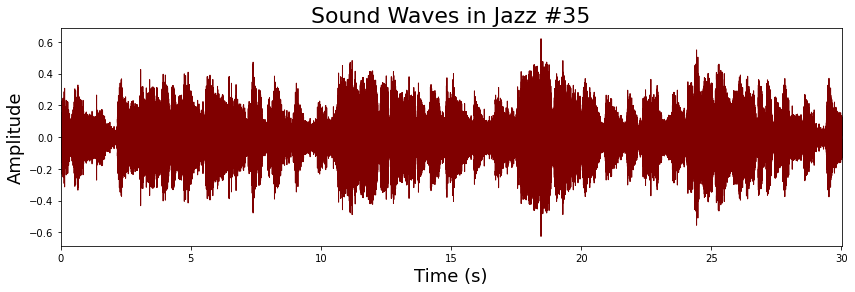

In [86]:
# We use our y and sr values to plot a graph showing the amplitude of the sound waves over time.
plt.figure(figsize = (14, 4))
librosa.display.waveplot(y = sample, sr = sr, color = "maroon");
plt.title("Sound Waves in Jazz #35", fontsize = 22);
plt.xlabel("Time (s)", fontsize = 18)
plt.ylabel("Amplitude", fontsize = 18)

## Short-Time Fourier Transform

Generating a spectogram involves applying a Short-Time-Fourier-Transform (STFT) to our sample, which takes a Fourier transform at a small number of frames and calculates the amplitudes of each frequency at that point. Spanned across the entire signal results in a spectrogram of the audio.

In [87]:
# Set variables:
n_fft = 2048
hop_length = 512 

# Short-time Fourier transform (STFT):
FT = np.abs(librosa.stft(sample, n_fft = n_fft, hop_length = hop_length))

# Converting the amplitude to decibels, i.e. changing the scale 
FTDB = librosa.amplitude_to_db(FT, ref = np.max)

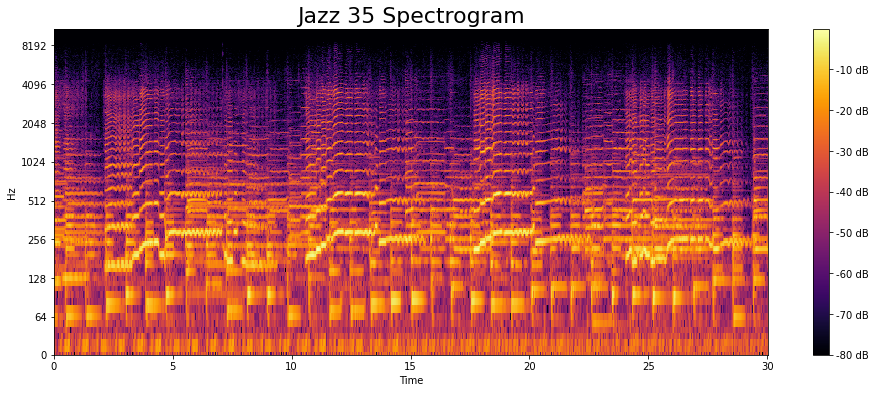

In [88]:
# Creating the Spectogram:
plt.figure(figsize = (16, 6))
librosa.display.specshow(FTDB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log', cmap = 'inferno')
plt.colorbar(format='%+2.0f dB');
plt.title("Jazz 35 Spectrogram", fontsize = 22);

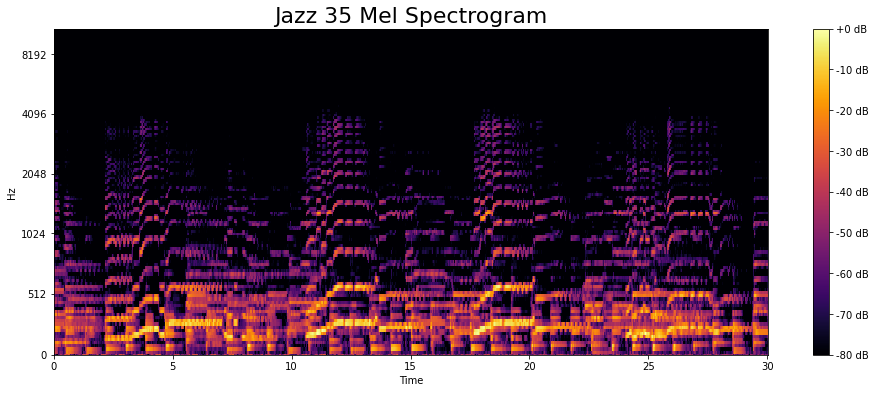

In [89]:
S = librosa.feature.melspectrogram(sample, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length = hop_length, x_axis = 'time', y_axis = 'mel', cmap = 'inferno');
plt.colorbar(format='%+2.0f dB');
plt.title("Jazz 35 Mel Spectrogram", fontsize = 22);

In [54]:
# Jazz 35 audio file:
Ipd.Audio(f'{path}/genres_original/jazz/jazz.00035.wav')

Above is a typical example of a spectogram for a jazz song. The brightness of the colour indicates the volume of the sound. From looking at the spectogram we can see that the jazz sample hits distinctive frequencies, with the lower frequencies being the loudest. This corresponds to the shart, distinct sound of the jazz music.

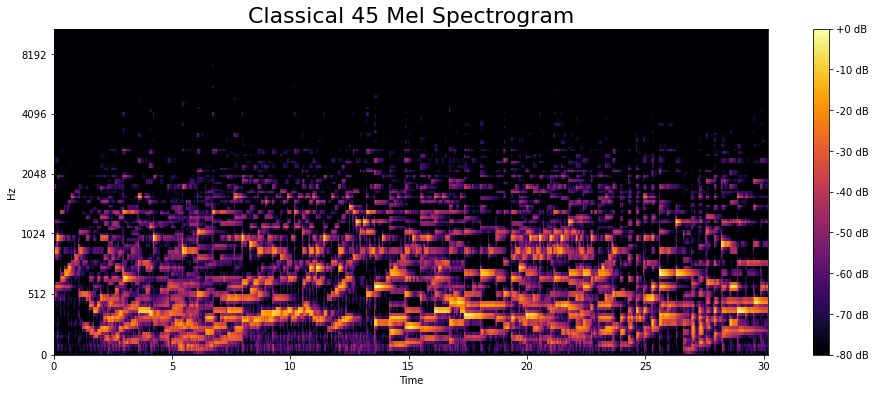

In [44]:
y, sr = librosa.load(f'{path}/genres_original/classical/classical.00045.wav')
sample = np.array(librosa.effects.trim(y))[0]

S = librosa.feature.melspectrogram(sample, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'mel', cmap = 'inferno');
plt.colorbar(format='%+2.0f dB');
plt.title("Classical 45 Mel Spectrogram", fontsize = 22);

In [45]:
# Classical 45 audio file:
Ipd.Audio(f'{path}/genres_original/classical/classical.00045.wav')

Our classical spectogram is similar to that of our jazz sample in that it shows a melodic pattern with the louder sounds concentrated to specific lower frequencies, with most of the higher frequencies not being hit.

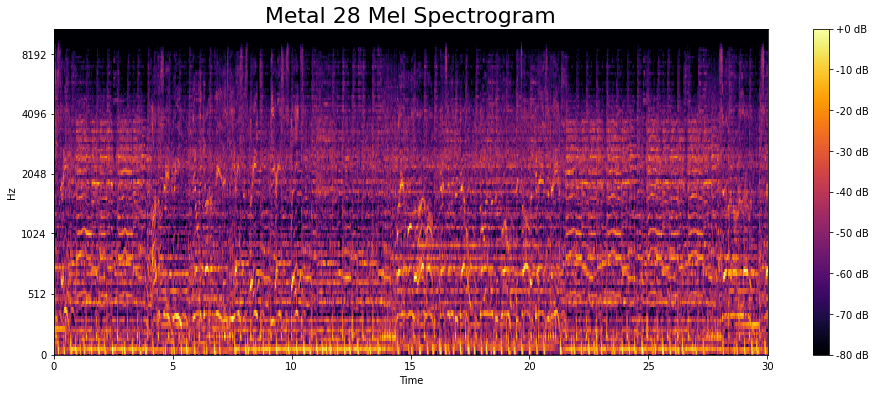

In [82]:
y, sr = librosa.load(f'{path}/genres_original/metal/metal.00028.wav')
sample = np.array(librosa.effects.trim(y))[0]

S = librosa.feature.melspectrogram(sample, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'mel', cmap = 'inferno');
plt.colorbar(format='%+2.0f dB');
plt.title("Metal 28 Mel Spectrogram", fontsize = 22);

In [80]:
# Jazz 35 audio file:
Ipd.Audio(f'{path}/genres_original/metal/metal.00028.wav')

In our metal spectogram above, the constant colour throughout shows that most frequencies appear in the audio all at once at various volumes, except the highest frequencies. Our metal spectogram differs from that of the jazz and classical spectograms because it describes a droney sound rather than a distinctive one.